In [40]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import random
import statistics

In [41]:
from collections import namedtuple, deque
from itertools import count
from PIL import Image

In [42]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

In [43]:
#from helpers import display_state
def display_state(state):
    fig, ax = plt.subplots(figsize=(1, 1))

    colors = ['yellow','green']

    color_indices = [0, 1]
    colormap = matplotlib.colors.ListedColormap(colors)

    ax.scatter([env.state[0], env.state[2]] , [env.state[1],env.state[3]], c=color_indices, cmap=colormap)

In [44]:
class Rewarder(nn.Module):
    def __init__(self, num_hidden_units, input_dim):
        super(Rewarder,self).__init__()
        
        self.rewarder_net = nn.Sequential(
            nn.Linear(input_dim, num_hidden_units),
            nn.ReLU(),
            nn.Linear(num_hidden_units,1)
        ) 
        
    def forward(self, input_obs):
        return int(self.rewarder_net(input_obs))
    

class Actor(nn.Module):
    def __init__(self, num_actions, num_hidden_units, input_dim):
        super(Actor,self).__init__()
        
        self.actor_net = nn.Sequential(
            nn.Linear(input_dim, num_hidden_units),
            nn.ReLU(),
            nn.Linear(num_hidden_units,num_actions),
            nn.Softmax(dim=0)
        ) 
        
        
    def forward(self, input_obs):
        return self.actor_net(input_obs)

In [48]:
class GridWorld():
    def __init__(self):
        self.state = self.init_state()
        self.step_count = 0
        
    def init_state(self):
        xs = random.sample(range(0,7),5)
        ys = random.sample(range(0,7),5)
        piece_pos = [xs[0], ys[0]]
        players_pos = [xs[4], ys[4]]
        positions = list(np.array([players_pos, piece_pos]).flatten())
        return positions
        
    def reset(self):
        self.state = self.init_state()
        self.step_count = 0
        
    def step(self, action):
        self.step_count += 1
        
        if (self.step_count == 0 % 10):
            print('count: ', self.step_count)
        
        if action == 0: #up
            self.state[1] += 1
            
        if action == 1: #right
            self.state[0] += 1
            
        if action == 2: #down
            self.state[1] -= 1
            
        if action == 3: #left
            self.state[0] -= 1
            
        if (self.step_count >= 25) : # loss max step
            self.reset()
            # reward function
            # with torch.no_grad():
            #    reward = int(rewarder(torch.unsqueeze(self.state, 0), training=False)[0])
            reward = int(rewarder(torch.Tensor(self.state).reshape(1,4)))
            playing = False
            
            return reward, playing
        
        if (self.state[0] == self.state[2]) and (self.state[1] == self.state[3]): # win the game
            playing = False
            reward = 100
            # reward learning model
            # with torch.no_grad():
            #    reward = int(rewarder(torch.unsqueeze(self.state, 0), training=False)[0])
            self.reset()
            return reward, playing
        
        playing = True

        # reward function
        #with torch.no_grad():
        #    reward = int(rewarder(torch.unsqueeze(self.state, 0), training=False)[0])
        reward = int(rewarder(torch.Tensor(self.state).reshape(1,4)))
        
        return reward, playing

State: [4, 6, 5, 3]
Reward: 0
State: [4, 7, 5, 3]


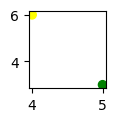

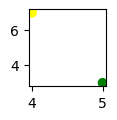

In [34]:
# test env 
rewarder = Rewarder(num_hidden_units = 64, input_dim = 4)
optimizer_rewarder = optim.Adam(rewarder.rewarder_net.parameters(), lr = 1e-2)

agent = Actor(num_actions = 4, num_hidden_units = 64, input_dim = 4)
optimizer_actor = optim.Adam(agent.actor_net.parameters(), lr = 1e-2)

criterion = nn.CrossEntropyLoss()


env = GridWorld()
print('State:', env.state)
display_state(env.state)

action_proba = agent(torch.Tensor(env.state).reshape(1,4))
action_index = torch.argmax(action_proba)
reward, playing = env.step(action_index)
print('Reward:',reward)
print('State:', env.state)
display_state(env.state)

In [46]:
# one complete episode
def step_episode(env, model_agent):
    env.reset()
    actions_proba_list = []
    rewards = []
    states = []
    actions = []
    playing = True
    
    while playing == True:
        observation = torch.Tensor(env.state).reshape(1,4)
        
        # run model
        action_proba = model_agent(observation)
        action_index = torch.argmax(action_proba)
        reward, playing = env.step(action_index)
        
        
        # save the data
        states.append(observation)
        actions_proba_list.append(action_proba)
        actions.append(action_index)
        rewards.append(reward)
        
    return  states, actions_proba_list, actions, rewards

State: [3, 1, 1, 4]


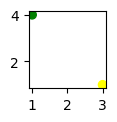

In [51]:
# test step episode
rewarder = Rewarder(num_hidden_units = 64, input_dim = 4)
optimizer_rewarder = optim.Adam(rewarder.rewarder_net.parameters(), lr = 1e-2)
agent = Actor(num_actions = 4, num_hidden_units = 64, input_dim = 4)
optimizer_actor = optim.Adam(agent.actor_net.parameters(), lr = 1e-2)

criterion = nn.CrossEntropyLoss()


env = GridWorld()
print('State:', env.state)
display_state(env.state)

states, actions_proba_list, actions, rewards = step_episode(env,agent)

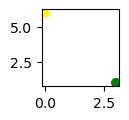

In [52]:
display_state(states[0])

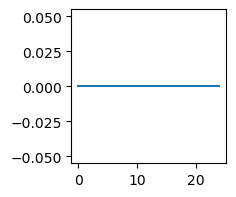

In [65]:
fig = plt.figure(figsize=(2, 2))
plt.plot(rewards)
plt.show()

In [69]:
print(states)

[tensor([[1., 1., 2., 3.]]), tensor([[1., 2., 2., 3.]]), tensor([[1., 3., 2., 3.]]), tensor([[1., 4., 2., 3.]]), tensor([[1., 5., 2., 3.]]), tensor([[1., 6., 2., 3.]]), tensor([[1., 7., 2., 3.]]), tensor([[1., 8., 2., 3.]]), tensor([[1., 9., 2., 3.]]), tensor([[ 1., 10.,  2.,  3.]]), tensor([[ 1., 11.,  2.,  3.]]), tensor([[ 1., 12.,  2.,  3.]]), tensor([[ 1., 13.,  2.,  3.]]), tensor([[ 1., 14.,  2.,  3.]]), tensor([[ 1., 15.,  2.,  3.]]), tensor([[ 1., 16.,  2.,  3.]]), tensor([[ 1., 17.,  2.,  3.]]), tensor([[ 1., 18.,  2.,  3.]]), tensor([[ 1., 19.,  2.,  3.]]), tensor([[ 1., 20.,  2.,  3.]]), tensor([[ 1., 21.,  2.,  3.]]), tensor([[ 1., 22.,  2.,  3.]]), tensor([[ 1., 23.,  2.,  3.]]), tensor([[ 1., 24.,  2.,  3.]]), tensor([[ 1., 25.,  2.,  3.]])]


In [78]:
# comparaison

transition_idx = random.sample(range(len(states)),2)
transition_samples = [states[transition_idx[0]], states[transition_idx[1]]]

print(transition_idx)
print(transition_samples)

[9, 5]
[tensor([[ 1., 10.,  2.,  3.]]), tensor([[1., 6., 2., 3.]])]


In [86]:
states[transition_idx[1]][0]

tensor([1., 6., 2., 3.])

In [133]:
# compare(transition_idx, states, actions)

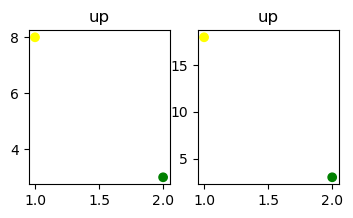

 select preference a:left, d:right, s:same a


TypeError: new() received an invalid combination of arguments - got (int, requires_grad=bool), but expected one of:
 * (*, torch.device device)
      didn't match because some of the keywords were incorrect: requires_grad
 * (torch.Storage storage)
 * (Tensor other)
 * (tuple of ints size, *, torch.device device)
 * (object data, *, torch.device device)


In [132]:
preference_update(states, actions, rewarder)

In [120]:
states[transition_idx[0]][0]

tensor([ 1., 10.,  2.,  3.])

In [124]:
reward_1 = torch.Tensor(rewarder((states[transition_idx[0]][0]).reshape(1,4)))
print(type(reward_1))

<class 'torch.Tensor'>


In [151]:
# here states ref to a lot of differents states
def preference_update( states, actions, rewarder):
    transition_idx = random.sample(range(len(states)),2)
    #transition_samples = [states[transition_idx[0]], states[transition_idx[1]]]

    compare(transition_idx, states, actions)
    pref = input (' select preference a:left, d:right, s:same ')
    if pref == 'a':
        dist = [ 1, 0 ]
    if pref == 'd':
        dist = [ 0, 1 ]
    if pref == 's':
        dist = [ 1, 1 ]
        
    # stuff gradient
    reward_1 = torch.Tensor(rewarder((states[transition_idx[0]][0]).reshape(1,4)), requires_grad=True)
    reward_2 = torch.Tensor(rewarder((states[transition_idx[1]][0]).reshape(1,4)), requires_grad=True)
    p1 = torch.exp(reward_1) / (torch.exp(reward_1) + torch.exp(reward_2))
    p2 = torch.exp(reward_2) / (torch.exp(reward_1) + torch.exp(reward_2))
    loss = - ( p1*dist[0] + p2*dist[1] )
    # rewarder.rewarder_net.zero_grad()
    optimizer_rewarder.zero_grad()
    loss.backward()
    optimizer_rewarder.step()   

In [170]:
dist = [1, 0]
reward_1 = torch.Tensor([rewarder((states[transition_idx[0]][0]).reshape(1,4))]).requires_grad_()
reward_2 = torch.Tensor([rewarder((states[transition_idx[1]][0]).reshape(1,4))]).requires_grad_()
p1 = torch.exp(reward_1) / (torch.exp(reward_1) + torch.exp(reward_2))
p2 = torch.exp(reward_2) / (torch.exp(reward_1) + torch.exp(reward_2))
loss = - ( p1*dist[0] + p2*dist[1] )
optimizer_rewarder.zero_grad()
loss.backward()
optimizer_rewarder.step()

In [171]:
rewarder.rewarder_net[0].weight[0]

tensor([-0.0116,  0.4717,  0.2444, -0.3736], grad_fn=<SelectBackward0>)

In [157]:
print(type(loss))

<class 'torch.Tensor'>


In [161]:
rewarder((states[transition_idx[0]][0]).reshape(1,4))

0

In [158]:
loss

tensor([-0.5000], grad_fn=<NegBackward0>)

In [115]:
def compare(transition_idx, mystates, actions):
    states = 0
    d1xs = [mystates[transition_idx[0]][0][0], mystates[transition_idx[0]][0][2]]
    d1ys = [mystates[transition_idx[0]][0][1], mystates[transition_idx[0]][0][3]]
    d2xs = [mystates[transition_idx[1]][0][0], mystates[transition_idx[1]][0][2]]
    d2ys = [mystates[transition_idx[1]][0][1], mystates[transition_idx[1]][0][3]]

    fig, ax = plt.subplots(1,2, figsize=(4, 2))
    colors = ['yellow','green']
    color_indices = [0, 1, ]
    colormap = matplotlib.colors.ListedColormap(colors)
    ax[0].scatter(d1xs, d1ys, c=color_indices, cmap=colormap)
    ax[0].set_title(str(decode_action(actions[transition_idx[0]].numpy())))
    ax[1].scatter(d2xs, d2ys, c=color_indices, cmap=colormap)
    ax[1].set_title(str(decode_action(actions[transition_idx[1]].numpy())))
    plt.show()

In [108]:
def decode_action(action):
    if action == 0:
        return 'up'
    if action == 1:
        return 'right'
    if action == 2:
        return 'down'
    if action == 3:
        return 'left'        

In [ ]:
def calc_g(reward_trajectory, gamma):
    ez_discount = np.array([ gamma**n for n in range(len(reward_trajectory))])
    gs = []
    reward_trajectory = np.array(reward_trajectory)
    for ts in range(len(reward_trajectory)):
        to_end_rewards = reward_trajectory[ts:]
        eq_len_discount = ez_discount[:len(reward_trajectory[ts:])]
        total_value = np.multiply(to_end_rewards, eq_len_discount)
        g = sum(total_value)
        gs.append(g)
    return gs   

In [ ]:
for episode in range(5000):
    action_probs, rewards, states ,actions = step_episode (env, agent)
    loss = actor_loss (action_probs ,rewards)

In [ ]:
# Define your reward model architecture
class RewardModel(nn.Module):
    def __init__(self):
        super(RewardModel, self).__init__()
        self.fc1 = nn.Linear(4, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Instantiate the reward model and define the optimizer
reward_model = RewardModel()
optimizer = optim.Adam(reward_model.parameters(), lr=0.001)

# Define the loss function
def preference_loss(reward_1, reward_2, dist):
    p1 = torch.exp(reward_1) / (torch.exp(reward_1) + torch.exp(reward_2))
    p2 = torch.exp(reward_2) / (torch.exp(reward_1) + torch.exp(reward_2))
    loss = - (p1*dist[0] + p2*dist[1])
    return loss

# Collect the human preference data and store it in a list
preference_data = [(state_1, state_2, distance), (state_3, state_4, distance)]

# Perform backpropagation on the reward model using the human preference data
for state_pair, dist in preference_data:
    state_1, state_2 = state_pair[0], state_pair[1]

    # Calculate the rewards for the two states in the pair
    reward_1 = reward_model(state_1)
    reward_2 = reward_model(state_2)

    # Compute the loss and perform backpropagation
    loss = preference_loss(reward_1, reward_2, dist)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()